# Salary Retirement Model in Python

This is a retirement model which models salary with both a constant growth rate for cost of living raises as well as regular salary increases for promotions. The model is broken up into the following sections:
- [**Setup**](#Setup): Runs any imports and other setup
- [**Inputs**](#Inputs): Defines the inputs for the model
- [**Salaries**](#Salaries): Determining the salary in each year, considering cost of living raises and promotions
- [**Wealths**](#Wealths): Determining the wealth in each year, considering a constant savings rate and investment rate
- [**Retirement**](#Retirement): Determines years to retirement from the wealths over time, the main output from the model.

## Setup

Setup for the later calculations are here. The necessary packages are imported.

In [1]:
from dataclasses import dataclass
import numpy_financial as npf

## Inputs

All of the inputs for the model are defined here. A class is constructed to manage the data, and an instance of the class containing the default inputs is created.

In [2]:
@dataclass
class ModelInputs:
    starting_salary: int = 60000
    promos_every_n_years: int = 5
    cost_of_living_raise: float = 0.02
    promo_raise: float = 0.15
    savings_rate: float = 0.25
    interest_rate: float = 0.05
    annual_cash_spend: int = 40000
    years_in_retirement: int = 25
    desired_cash: int = 1500000
        
model_data = ModelInputs()
model_data

ModelInputs(starting_salary=60000, promos_every_n_years=5, cost_of_living_raise=0.02, promo_raise=0.15, savings_rate=0.25, interest_rate=0.05, annual_cash_spend=40000, years_in_retirement=25, desired_cash=1500000)

In [3]:
def dynamic_desired_cash(annual_cash_spend, years_in_retirement, interest_rate):
    # I used the present value of an annuity formula to calculate how much is needed to spend 
    # for n years in retirement
    desired_cash = npf.pv(rate=interest_rate, nper=years_in_retirement, pmt=-annual_cash_spend, fv=0)
    return abs(desired_cash)

## Salaries

Here the salary for each year is calculated. We assume that the salary grows at a constant rate each year for cost of living raises, and then also every number of years, the salary increases by a further percentage due to a promotion or switching jobs. Based on this assumption, the salary would evolve over time with the following equation:

$$s_t = s_0 (1 + r_{cl})^n (1 + r_p)^p$$

Where:
- $s_t$: Salary at year $t$
- $s_0$: Starting salary (year 0)
- $r_{cl}$: Annual cost of living raise
- $r_p$: Promotion raise
- $p$: Number of promotions

And in Python format:

In [4]:
def salary_at_year(data: ModelInputs, year):
    """
    Gets the salary at a given year from the start of the model based on cost of living raises and regular promotions.
    """
    # Every n years we have a promotion, so dividing the years and taking out the decimals gets the number of promotions
    num_promos = int(year / data.promos_every_n_years)
    
    # This is the formula above implemented in Python
    salary_t = data.starting_salary * (1 + data.cost_of_living_raise) ** year * (1 + data.promo_raise) ** num_promos
    return salary_t

That function will get the salary at a given year, so to get all the salaries we just run it on each year. But we will not know how many years to run as we should run it until the individual is able to retire. So we are just showing the first few salaries for now and will later use this function in the [Wealths](#Wealths) section of the model.

In [5]:
for i in range(6):
    year = i + 1
    salary = salary_at_year(model_data, year)
    print(f'The salary at year {year} is ${salary:,.0f}.')

The salary at year 1 is $61,200.
The salary at year 2 is $62,424.
The salary at year 3 is $63,672.
The salary at year 4 is $64,946.
The salary at year 5 is $76,182.
The salary at year 6 is $77,705.


As expected, with the default inputs, the salary is increasing at 2% per year. Then at year 5, there is a promotion so there is a larger increase in salary.

## Wealths

The wealths portion of the model is concerned with applying the savings rate to the earned salary to calculate the cash saved, accumulating the cash saved over time, and applying the investment rate to the accumulated wealth.

To calculate cash saved, it is simply:

$$c_t = s_t * r_s$$

Where:
- $c_t$: Cash saved during year $t$
- $r_s$: Savings rate

In [6]:
def cash_saved_during_year(data: ModelInputs, year):
    """
    Calculated the cash saved within a given year, by first calculating the salary at that year then applying the 
    savings rate.
    """
    salary = salary_at_year(data, year)
    cash_saved = salary * data.savings_rate
    return cash_saved

To get the wealth at each year, it is just applying the investment return to last year's wealth, then adding this year's cash saved:

$$w_t = w_{t-1} (1 + r_i) + c_t$$
Where:
- $w_t$: Wealth at year $t$
- $r_i$: Investment rate

In [7]:
def wealth_at_year(data: ModelInputs, year, prior_wealth):
    """
    Calculate the accumulated wealth for a given year, based on previous wealth, the investment rate,
    and cash saved during the year.
    """
    cash_saved = cash_saved_during_year(data, year)
    wealth = prior_wealth * (1 + data.interest_rate) + cash_saved
    return wealth

Again, just like in the [Salaries](#Salaries) section, we can now get the output for each year, but we don't know ultimately how many years we will have to run it. That will be determined in the [Retirement](#Retirement) section. So for now, just show the first few years of wealth accumulation:

In [8]:
prior_wealth = 0  # starting with no cash saved
for i in range(6):
    year = i + 1
    wealth = wealth_at_year(model_data, year, prior_wealth)
    print(f'The wealth at year {year} is ${wealth:,.0f}.')
    
    # Set next year's prior wealth to this year's wealth
    prior_wealth = wealth

The wealth at year 1 is $15,300.
The wealth at year 2 is $31,671.
The wealth at year 3 is $49,173.
The wealth at year 4 is $67,868.
The wealth at year 5 is $90,307.
The wealth at year 6 is $114,248.


With default inputs, the wealth is going up by approximately 25% of the salary each year, plus a bit more for investment. Then in year 6 we see a substantially larger increase because the salary is substantially larger due to the promotion. So everything is looking correct.

## Retirement

This section of the model puts everything together to produce the final output of years to retirement. It uses the logic to get the wealths at each year, which in turn uses the logic to the get salary at each year. The wealth at each year is tracked over time until it hits the desired cash. Once the wealth hits the desired cash, the individual is able to retire so that year is returned as the years to retirement.

In [9]:
def years_to_retirement(data: ModelInputs, print_output = False):
    
    # Calculate annual savings from the salary and savings rate
    annual_savings = model_data.starting_salary * model_data.savings_rate
    
    # Calculate the dynamic desired_cash using the new inputs
    data.desired_cash = dynamic_desired_cash(
        model_data.annual_cash_spend,
        model_data.years_in_retirement,
        model_data.interest_rate
    )
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    year = 0  # will become 1 on first loop
    if print_output:
        print('Wealths over time:') # \n makes a blank line in the output.
    while wealth < data.desired_cash:
        year = year + 1
        wealth = wealth_at_year(data, year, prior_wealth)
        if print_output:
            print(f'The wealth at year {year} is ${wealth:,.0f}.')

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        
    # Now we have exited the while loop, so wealth must be >= desired_cash. Whatever last year was set
    # is the years to retirement.
    if print_output:
        print(f'\nRetirement:\nIt will take {year} years to retire.')  # \n makes a blank line in the output.
    return year

With the default inputs:

In [10]:
years = years_to_retirement(model_data)

## Sensitivity Analysis

In [22]:
import sensitivity
import pandas as pd
from sensitivity import SensitivityAnalyzer
import random

In [12]:
# create a function that takes the separate arguments, create a dataclass from those arguments 
# pass the dataclass into the function and returns the results 
# arbitrary
def y2r_separate_args(**kwargs):
    print(kwargs)
    data = ModelInputs(**kwargs)
    return years_to_retirement(data)

y2r_separate_args()

{}


18

In [13]:
[i for i in range(4,8)]

[4, 5, 6, 7]

In [14]:
sensitivity_val = {
    'starting_salary':[i * 10000 for i in range(4,8)],
    'promos_every_n_years':[i for i in range(4,8)],
    'cost_of_living_raise':[i / 100 for i in range(1,4)],
    'promo_raise': [i/100 for i in range(10,25,5)],
    'interest_rate': [i/100 for i in range(3,7)],
    'savings_rate':[i/100 for i in range(10,40,10)],
    'desired_cash': [i * 1000000 for i in range(10,26,5)],
}

labels = {
    'starting_salary' : "Starting Salary",
    'promos_every_n_years' : 'Step-Year Promotion',
    'cost_of_living_raise': 'Cost of Living Raise',
    'promo_raise': 'Promo Raise',
    'interest_rate': "Interest Rate",
    'savings_rate': 'Savings Rate',
    'desired_cash': 'Desired Cash',
    
}

sa = SensitivityAnalyzer (
    sensitivity_val,
    y2r_separate_args,
    result_name= "Years to Retirement",
    reverse_colors = True,
    grid_size=3,
    labels = labels,
    num_fmt='{:.0f}'
    )

  3%|█                                     | 195/6912 [00:00<00:03, 1945.72it/s]

{'starting_salary': 40000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 10000000}
{'starting_salary': 40000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 15000000}
{'starting_salary': 40000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 20000000}
{'starting_salary': 40000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 40000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 40000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'sa

  6%|██▎                                   | 417/6912 [00:00<00:03, 2105.68it/s]

{'starting_salary': 40000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 40000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 40000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 40000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 40000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 40000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.0

  9%|███▌                                  | 656/6912 [00:00<00:02, 2231.76it/s]

{'starting_salary': 40000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 40000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 40000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 20000000}
{'starting_salary': 40000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 25000000}
{'starting_salary': 40000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 10000000}
{'starting_salary': 40000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.0

 13%|████▉                                 | 901/6912 [00:00<00:02, 2317.19it/s]

{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'sa

 16%|██████                               | 1133/6912 [00:00<00:02, 2175.05it/s]

{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 40000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'sa

 20%|███████▏                             | 1352/6912 [00:00<00:02, 2087.68it/s]

{'starting_salary': 40000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 40000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 40000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 40000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 40000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 40000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.03, 'sa

 23%|████████▍                            | 1583/6912 [00:00<00:02, 2156.03it/s]

{'starting_salary': 40000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 40000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 40000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 20000000}
{'starting_salary': 40000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 25000000}
{'starting_salary': 40000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 10000000}
{'starting_salary': 40000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.06, 'sa

 26%|█████████▊                           | 1822/6912 [00:00<00:02, 2226.93it/s]

{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.05, 'savings_rate': 0.1, 'desired_cash': 10000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.05, 'savings_rate': 0.1, 'desired_cash': 15000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.05, 'savings_rate': 0.1, 'desired_cash': 20000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.05, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.05, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.05, 'sa

 30%|██████████▉                          | 2051/6912 [00:00<00:02, 2244.06it/s]

{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 20000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 25000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 10000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 15000000}
{'starting_salary': 50000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.06, 'sa

 33%|████████████▎                        | 2308/6912 [00:01<00:01, 2341.29it/s]

{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 15000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 20000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.03, 'sa

 37%|█████████████▋                       | 2558/6912 [00:01<00:01, 2387.61it/s]

{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 20000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 50000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.04, 'sa

 44%|████████████████▍                    | 3068/6912 [00:01<00:01, 2470.28it/s]

{'starting_salary': 50000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 50000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 50000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 50000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 50000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 50000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.0

{'starting_salary': 50000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.01, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 50000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.01, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 20000000}
{'starting_salary': 50000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.01, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 25000000}
{'starting_salary': 50000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.01, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 10000000}
{'starting_salary': 50000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.01, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 15000000}
{'starting_salary': 50000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.01, 'promo_raise': 0.15, 'interest_rate': 0.0

 51%|███████████████████                  | 3556/6912 [00:01<00:01, 2324.59it/s]

{'starting_salary': 50000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 50000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 50000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 50000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 20000000}
{'starting_salary': 50000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 25000000}
{'starting_salary': 50000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.06, 'sa

{'starting_salary': 60000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 60000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 20000000}
{'starting_salary': 60000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 25000000}
{'starting_salary': 60000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 10000000}
{'starting_salary': 60000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 15000000}
{'starting_salary': 60000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.06, 'sa

 59%|█████████████████████▋               | 4051/6912 [00:01<00:01, 2399.48it/s]

{'starting_salary': 60000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 60000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 20000000}
{'starting_salary': 60000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 25000000}
{'starting_salary': 60000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 10000000}
{'starting_salary': 60000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 15000000}
{'starting_salary': 60000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.04, 'sa

{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.05, 'savings_rate': 0.3, 'desired_cash': 25000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 10000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 15000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 20000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.02, 'promo_raise': 0.15, 'interest_rate': 0.0

 66%|████████████████████████▎            | 4543/6912 [00:01<00:01, 2358.53it/s]

{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 20000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 25000000}
{'starting_salary': 60000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.04, 'sa

{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.1, 'desired_cash': 10000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.1, 'desired_cash': 15000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.1, 'desired_cash': 20000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.02, 'promo_raise': 0.2, 'interest_rate': 0.05, 'sa

 73%|██████████████████████████▉          | 5022/6912 [00:02<00:00, 2330.51it/s]

{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.05, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 60000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.05, 'sa

{'starting_salary': 60000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 20000000}
{'starting_salary': 60000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 60000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 60000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 60000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 60000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.03, 'promo_raise': 0.1, 'interest_rate': 0.04, 'sa

 79%|█████████████████████████████▎       | 5487/6912 [00:02<00:00, 2300.94it/s]

{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.04, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.04, 'sa

{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 20000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 70000, 'promos_every_n_years': 4, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.0

 86%|███████████████████████████████▉     | 5955/6912 [00:02<00:00, 2235.87it/s]

{'starting_salary': 70000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 20000000}
{'starting_salary': 70000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.06, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 70000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 70000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 70000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.06, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 70000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.01, 'promo_raise': 0.1, 'interest_rate': 0.06, 'sa

{'starting_salary': 70000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 25000000}
{'starting_salary': 70000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 10000000}
{'starting_salary': 70000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 15000000}
{'starting_salary': 70000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 20000000}
{'starting_salary': 70000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 70000, 'promos_every_n_years': 5, 'cost_of_living_raise': 0.03, 'promo_raise': 0.15, 'interest_rate': 0.0

 93%|██████████████████████████████████▍  | 6427/6912 [00:02<00:00, 2301.22it/s]

{'starting_salary': 70000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.01, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 70000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.01, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 70000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.01, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 70000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.01, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 15000000}
{'starting_salary': 70000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.01, 'promo_raise': 0.15, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 20000000}
{'starting_salary': 70000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.01, 'promo_raise': 0.15, 'interest_rate': 0.0

{'starting_salary': 70000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 70000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 70000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 70000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.2, 'desired_cash': 25000000}
{'starting_salary': 70000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.03, 'savings_rate': 0.3, 'desired_cash': 10000000}
{'starting_salary': 70000, 'promos_every_n_years': 6, 'cost_of_living_raise': 0.03, 'promo_raise': 0.2, 'interest_rate': 0.03, 'sa

100%|█████████████████████████████████████| 6912/6912 [00:03<00:00, 2298.24it/s]

{'starting_salary': 70000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 20000000}
{'starting_salary': 70000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.04, 'savings_rate': 0.1, 'desired_cash': 25000000}
{'starting_salary': 70000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 10000000}
{'starting_salary': 70000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 15000000}
{'starting_salary': 70000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.04, 'savings_rate': 0.2, 'desired_cash': 20000000}
{'starting_salary': 70000, 'promos_every_n_years': 7, 'cost_of_living_raise': 0.01, 'promo_raise': 0.2, 'interest_rate': 0.04, 'sa

In [15]:
sa.df

,Starting Salary,Step-Year Promotion,Cost of Living Raise,Promo Raise,Interest Rate,Savings Rate,Desired Cash,Years to Retirement
0,40000,4,0.01,0.1,0.03,0.1,10000000,41
1,40000,4,0.01,0.1,0.03,0.1,15000000,41
2,40000,4,0.01,0.1,0.03,0.1,20000000,41
3,40000,4,0.01,0.1,0.03,0.1,25000000,41
4,40000,4,0.01,0.1,0.03,0.2,10000000,30
...,...,...,...,...,...,...,...,...
6907,70000,7,0.03,0.2,0.06,0.2,25000000,17
6908,70000,7,0.03,0.2,0.06,0.3,10000000,14
6909,70000,7,0.03,0.2,0.06,0.3,15000000,14
6910,70000,7,0.03,0.2,0.06,0.3,20000000,14


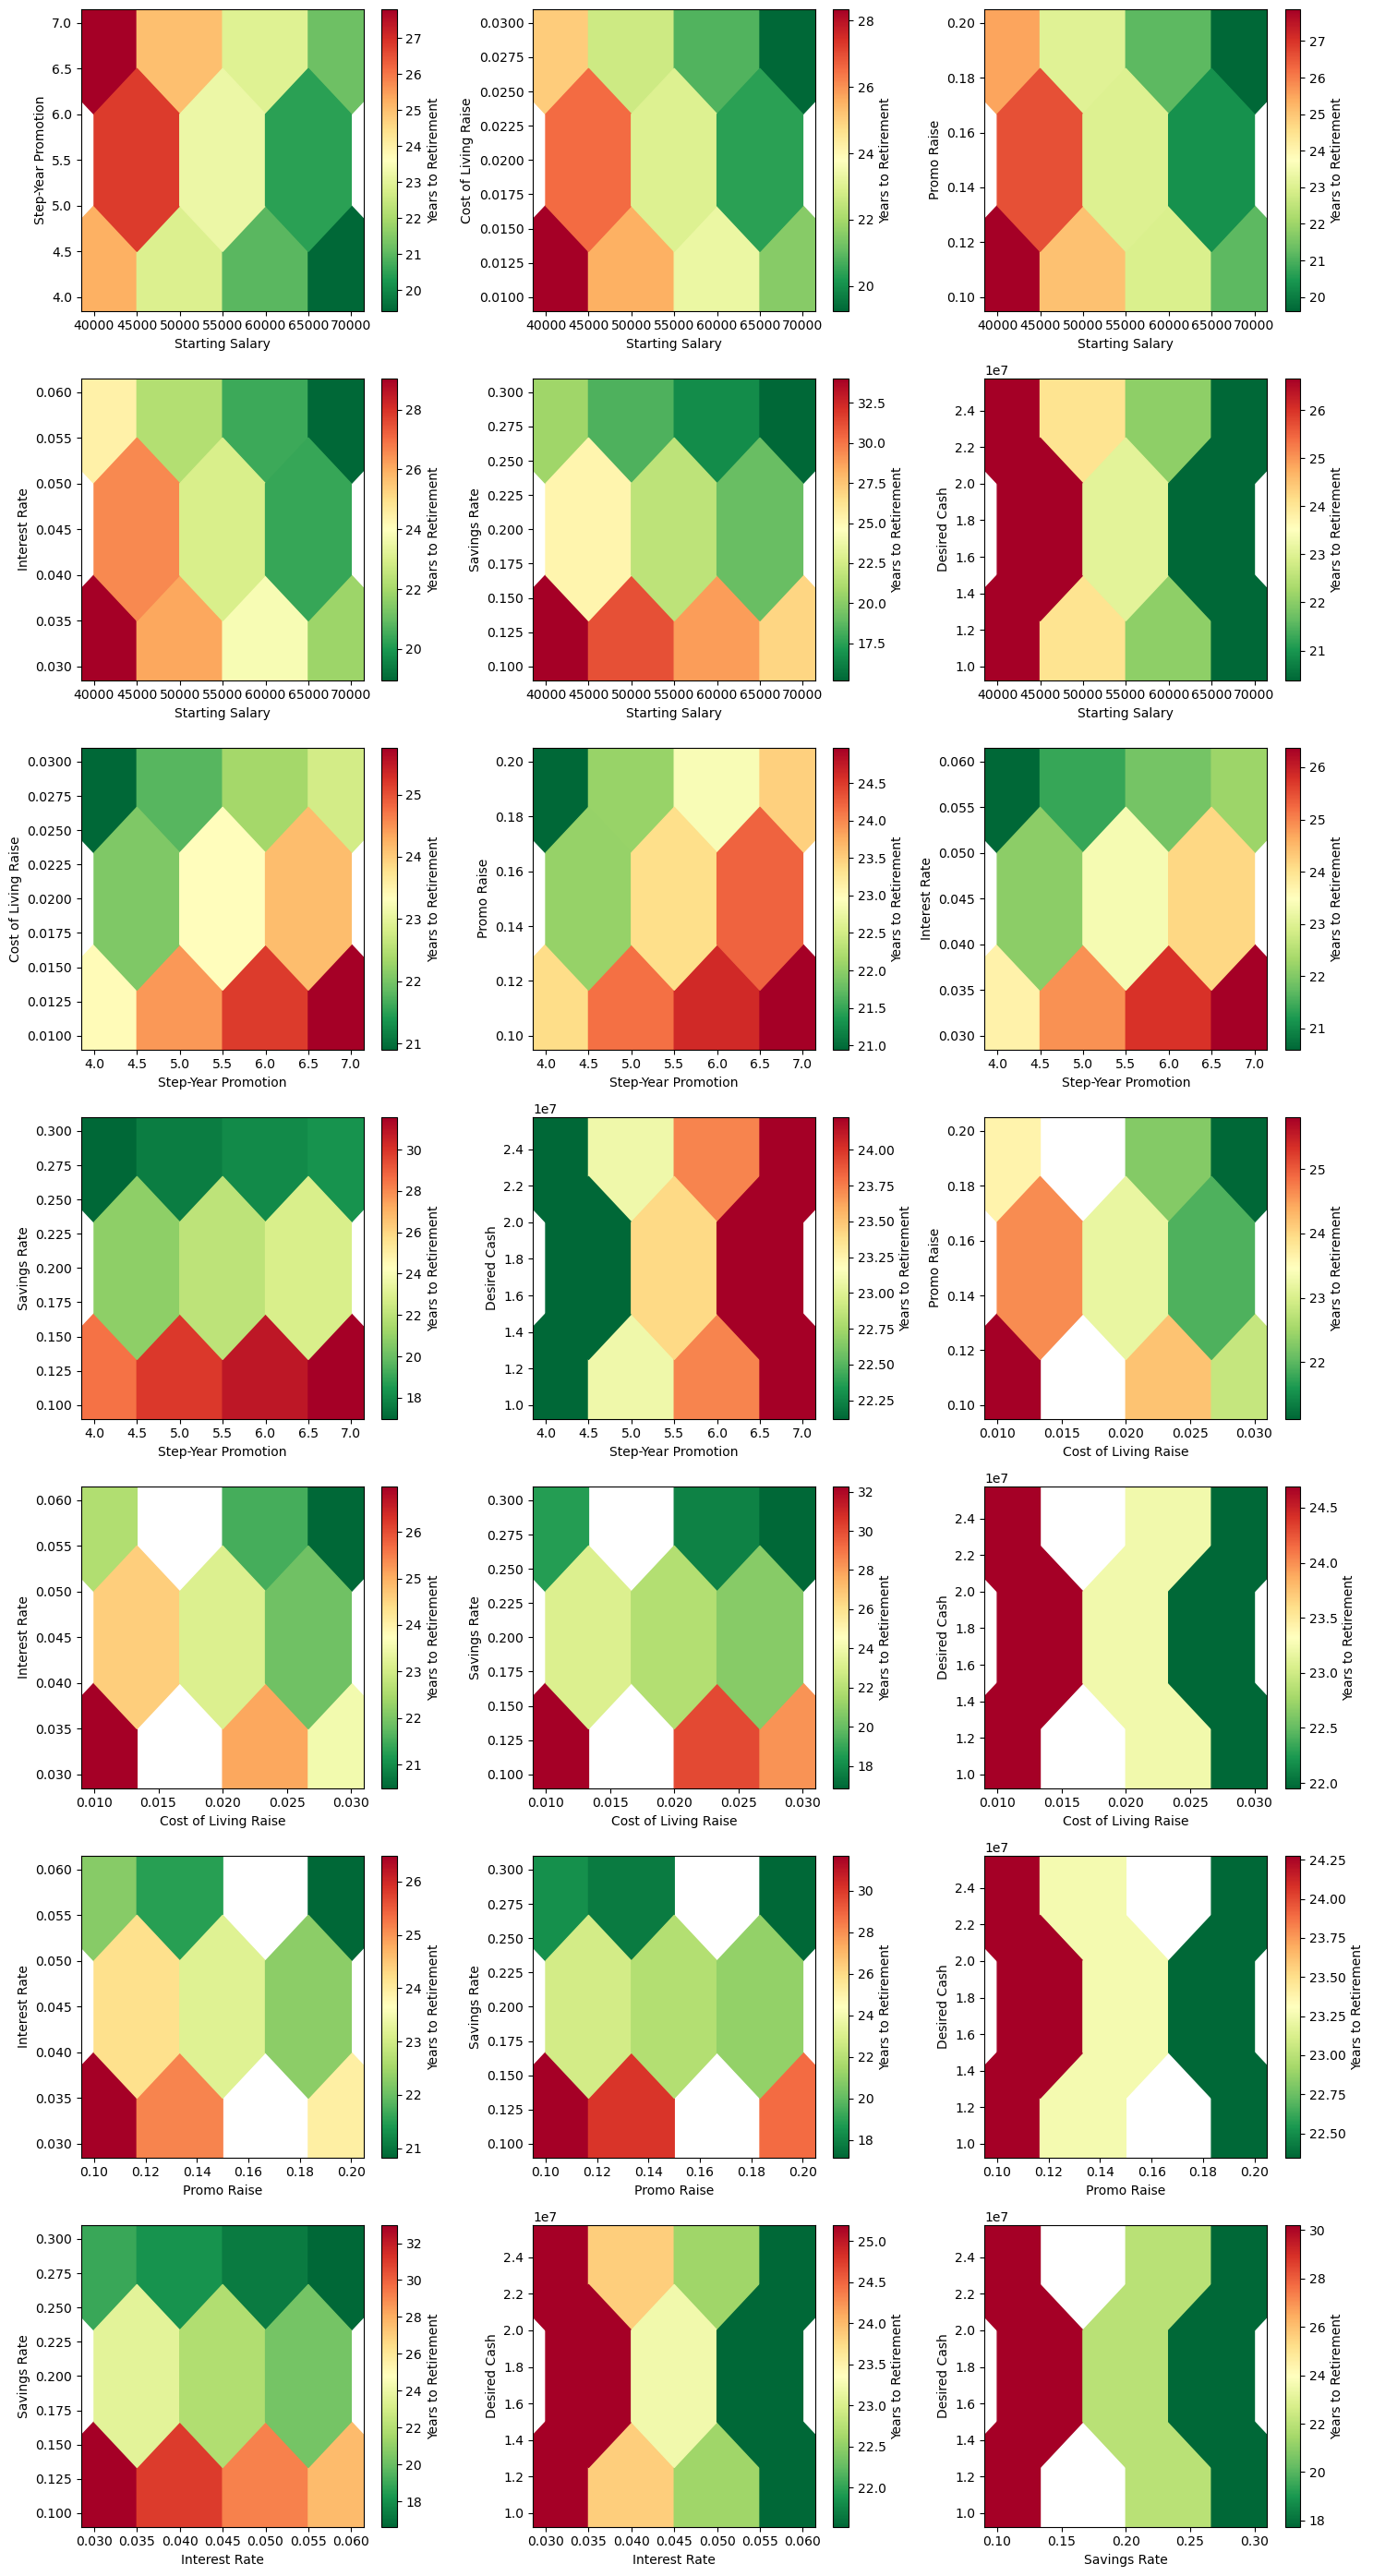

In [16]:
plot = sa.plot()

In [17]:
styled_df = sa.styled_dfs()

,4,5,6,7
Starting Salary,,,,
40000,25,26,27,28
50000,23,24,25,25
60000,21,22,22,23
70000,19,20,21,21


,0.010000,0.020000,0.030000
Starting Salary,,,
40000,28,27,25
50000,26,24,23
60000,23,22,21
70000,22,20,19


,0.100000,0.150000,0.200000
Starting Salary,,,
40000,28,27,25
50000,25,24,23
60000,23,22,21
70000,21,20,20


,0.030000,0.040000,0.050000,0.060000
Starting Salary,,,,
40000,29,27,26,24
50000,26,25,23,22
60000,24,23,21,20
70000,22,21,20,19


,0.100000,0.200000,0.300000
Starting Salary,,,
40000,34,25,21
50000,31,23,18
60000,29,21,17
70000,27,19,15


,10000000,15000000,20000000,25000000
Starting Salary,,,,
40000,27,27,27,27
50000,24,24,24,24
60000,22,22,22,22
70000,20,20,20,20


,0.010000,0.020000,0.030000
Step-Year Promotion,,,
4,23,22,21
5,24,23,22
6,25,24,22
7,26,24,23


,0.100000,0.150000,0.200000
Step-Year Promotion,,,
4,23,22,21
5,24,23,22
6,25,24,23
7,25,24,23


,0.030000,0.040000,0.050000,0.060000
Step-Year Promotion,,,,
4,24,23,22,21
5,25,24,22,21
6,26,24,23,22
7,26,25,23,22


,0.100000,0.200000,0.300000
Step-Year Promotion,,,
4,29,21,17
5,30,22,18
6,31,22,18
7,32,23,18


,10000000,15000000,20000000,25000000
Step-Year Promotion,,,,
4,22,22,22,22
5,23,23,23,23
6,24,24,24,24
7,24,24,24,24


,0.100000,0.150000,0.200000
Cost of Living Raise,,,
0.010000,26,25,24
0.020000,24,23,22
0.030000,23,22,21


,0.030000,0.040000,0.050000,0.060000
Cost of Living Raise,,,,
0.010000,27,25,24,23
0.020000,25,24,23,22
0.030000,24,22,21,20


,0.100000,0.200000,0.300000
Cost of Living Raise,,,
0.010000,32,23,19
0.020000,30,22,18
0.030000,28,21,17


,10000000,15000000,20000000,25000000
Cost of Living Raise,,,,
0.010000,25,25,25,25
0.020000,23,23,23,23
0.030000,22,22,22,22


,0.030000,0.040000,0.050000,0.060000
Promo Raise,,,,
0.100000,26,25,23,22
0.150000,25,24,23,22
0.200000,24,23,22,21


,0.100000,0.200000,0.300000
Promo Raise,,,
0.100000,32,23,18
0.150000,30,22,18
0.200000,29,21,17


,10000000,15000000,20000000,25000000
Promo Raise,,,,
0.100000,24,24,24,24
0.150000,23,23,23,23
0.200000,22,22,22,22


,0.100000,0.200000,0.300000
Interest Rate,,,
0.030000,33,24,19
0.040000,31,22,18
0.050000,29,21,17
0.060000,28,20,17


,10000000,15000000,20000000,25000000
Interest Rate,,,,
0.030000,25,25,25,25
0.040000,24,24,24,24
0.050000,23,23,23,23
0.060000,22,22,22,22


,10000000,15000000,20000000,25000000
Savings Rate,,,,
0.100000,30,30,30,30
0.200000,22,22,22,22
0.300000,18,18,18,18


## Scenario Analysis

In [18]:
# set up the different input cases for the scenarios using a dictionary

bad_economy_data = ModelInputs(
    
    starting_salary = 40000,
    promos_every_n_years = 8,
    cost_of_living_raise = 0.01,
    promo_raise = 0.07,
    savings_rate = 0.15,
    interest_rate = 0.03
)

good_economy_data = ModelInputs(
    
    starting_salary = 70000,
    promos_every_n_years = 4,
    cost_of_living_raise = 0.03,
    promo_raise = 0.2,
    savings_rate = 0.35,
    interest_rate = 0.06
)

cases = {
    'Recession': bad_economy_data,
    'Normal': model_data,
    'Expansion': good_economy_data
}

In [19]:
# years to retirement for this model

for case_type, case_inputs in cases.items():
#     print(case_type,case_inputs)
    ytr = years_to_retirement(case_inputs, print_output = False)
    print(f'It would take {ytr} years to retire in a {case_type} economy.')

It would take 39 years to retire in a Recession economy.
It would take 18 years to retire in a Normal economy.
It would take 12 years to retire in a Expansion economy.


In [20]:
# take an expected value across the different scenarios and results with probabilities

case_probabilities = {
    'Recession': 0.2,
    'Normal': 0.5,
    'Expansion': 0.3
}

# calculate the expected value based on the probabilities - each probability * output - using a running total loop

expected_ytr = 0
for case_type, case_inputs in cases.items():
#     print(case_type,case_inputs)
    ytr = years_to_retirement(case_inputs, print_output = False)
    weighted_ytr = ytr * case_probabilities[case_type]
    expected_ytr = expected_ytr + weighted_ytr
print(f'It would take {expected_ytr} years to retire in a {case_type} economy given a {case_probabilities["Recession"]:.0%} of recession and a {case_probabilities["Expansion"]:.0%} of an expansionary economy.')

It would take 20.4 years to retire in a Expansion economy given a 20% of recession and a 30% of an expansionary economy.


## Internal Randomness

In [75]:
@dataclass
class ModelInputs:
    starting_salary: tuple = (40000,60000,70000)
    promos_every_n_years: tuple = (8,5,4)
    cost_of_living_raise: tuple = (0.01, 0.02, 0.03)
    promo_raise: tuple = (0.07,0.15,0.2)
    savings_rate: tuple = (0.15,0.25,0.35)
    interest_rate: tuple = (0.03,0.05,0.06)
    desired_cash: int = 1500000
    recession_prob: float = 0.2
    expansion_prob: float = 0.3
    case_names: tuple = ('Recession', 'Normal', 'Expansion')
    n_iter: int = 1000
        
model_data = ModelInputs()
model_data

ModelInputs(starting_salary=(40000, 60000, 70000), promos_every_n_years=(8, 5, 4), cost_of_living_raise=(0.01, 0.02, 0.03), promo_raise=(0.07, 0.15, 0.2), savings_rate=(0.15, 0.25, 0.35), interest_rate=(0.03, 0.05, 0.06), desired_cash=1500000, recession_prob=0.2, expansion_prob=0.3, case_names=('Recession', 'Normal', 'Expansion'), n_iter=1000)

In [76]:
data = model_data

In [77]:
# we want to create a function where we can automatically tell whether we are in recession, normal or expansion period
def economy_status(data):
    normal_probability = 1 - data.recession_prob - data.expansion_prob
    economy_state = random.choices([0,1,2], weights = [data.recession_prob, normal_probability, data.expansion_prob])[0]
    return economy_state

economy_status(model_data)

1

In [54]:
case = economy_status(data)

In [78]:
# new functions based on economic conditions based on scenario analysis

def salary_at_year(data: ModelInputs, year, case):
    """
    Gets the salary at a given year from the start of the model based on cost of living raises and regular promotions.
    """
    # Every n years we have a promotion, so dividing the years and taking out the decimals gets the number of promotions
    num_promos = int(year / data.promos_every_n_years [case])
    
    # This is the formula above implemented in Python
    salary_t = data.starting_salary [case] * (1 + data.cost_of_living_raise [case]) ** year * (1 + data.promo_raise[case]) ** num_promos
    return salary_t

def cash_saved_during_year(data: ModelInputs, year, case):
    """
    Calculated the cash saved within a given year, by first calculating the salary at that year then applying the 
    savings rate.
    """
    salary = salary_at_year(data, year, case)
    cash_saved = salary * data.savings_rate [case]
    return cash_saved

def wealth_at_year(data: ModelInputs, year, prior_wealth, case):
    """
    Calculate the accumulated wealth for a given year, based on previous wealth, the investment rate,
    and cash saved during the year.
    """
    cash_saved = cash_saved_during_year(data, year, case)
    wealth = prior_wealth * (1 + data.interest_rate[case]) + cash_saved
    return wealth

def years_to_retirement(data: ModelInputs, print_output = True):
    
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    year = 0  # will become 1 on first loop
    if print_output:
        print('Wealths over time:') # \n makes a blank line in the output.
    while wealth < data.desired_cash:
        year = year + 1
        case = economy_status(data) #we want to get the case for every year
        case_type = data.case_names[case]
        wealth = wealth_at_year(data, year, prior_wealth, case)
        if print_output:
            print(f'The wealth at year {year} ({case_type} economy)is ${wealth:,.0f}.')

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        
    # Now we have exited the while loop, so wealth must be >= desired_cash. Whatever last year was set
    # is the years to retirement.
    if print_output:
        print(f'\nRetirement:\nIt will take {year} years to retire.')  # \n makes a blank line in the output.
    return year

In [79]:
# run the model based on the new adjustments
years_to_retirement(model_data)

Wealths over time:
The wealth at year 1 (Normal economy)is $15,300.
The wealth at year 2 (Normal economy)is $31,671.
The wealth at year 3 (Expansion economy)is $60,343.
The wealth at year 4 (Normal economy)is $79,597.
The wealth at year 5 (Normal economy)is $102,622.
The wealth at year 6 (Normal economy)is $127,179.
The wealth at year 7 (Recession economy)is $137,428.
The wealth at year 8 (Recession economy)is $148,502.
The wealth at year 9 (Normal economy)is $176,543.
The wealth at year 10 (Normal economy)is $209,552.
The wealth at year 11 (Normal economy)is $244,695.
The wealth at year 12 (Normal economy)is $282,088.
The wealth at year 13 (Normal economy)is $321,855.
The wealth at year 14 (Normal economy)is $364,122.
The wealth at year 15 (Expansion economy)is $451,928.
The wealth at year 16 (Normal economy)is $505,842.
The wealth at year 17 (Normal economy)is $563,078.
The wealth at year 18 (Normal economy)is $623,814.
The wealth at year 19 (Normal economy)is $688,240.
The wealth at

27

In [87]:
# because we are getting several outputs from our model due to internal randomness everytime we run the model
# we want to build a for loop that will enable us to run the models a certain number of times and summarize the results

all_ytrs = []
for i in range(data.n_iter):
    ytr = years_to_retirement (data, print_output = False)
    all_ytrs.append (ytr)
    
df_ytr = pd.DataFrame()
df_ytr['Years to Retirement'] = all_ytrs

In [97]:
avg_ytr = df_ytr['Years to Retirement'].mean()
std_ytr = df_ytr['Years to Retirement'].std()
max_ytr = df_ytr['Years to Retirement'].max()
min_ytr = df_ytr['Years to Retirement'].min()

print(
    f'It will take an average of {avg_ytr:.0f} years to retire with a standard deviation of {std_ytr:.0f} years' 
    f', a max of {max_ytr:.0f} years , and a minimum of {min_ytr:.0f} years')

It will take an average of 26 years to retire with a standard deviation of 2 years, a max of 31 years , and a minimum of 21 years


In [98]:
# bringing the 2 new logics together as a summarized function
def ytr_all_cases(data):
    all_ytrs = []
    for i in range(data.n_iter):
        ytr = years_to_retirement (data, print_output = False)
        all_ytrs.append (ytr)

    df_ytr = pd.DataFrame()
    df_ytr['Years to Retirement'] = all_ytrs
    return df_ytr

def summarise_ytr(df_ytr):

    avg_ytr = df_ytr['Years to Retirement'].mean()
    std_ytr = df_ytr['Years to Retirement'].std()
    max_ytr = df_ytr['Years to Retirement'].max()
    min_ytr = df_ytr['Years to Retirement'].min()

    print(
        f'It will take an average of {avg_ytr:.0f} years to retire with a standard deviation of {std_ytr:.0f} years' 
        f', a max of {max_ytr:.0f} years , and a minimum of {min_ytr:.0f} years')

# bringing both functions into a summary function for internal randomness

def summarize_ytr_all_cases(data):
    df_ytr = ytr_all_cases(data)
    summarise_ytr(df_ytr)

In [102]:
# now passing the summary function using a flexible desired cash
summarize_ytr_all_cases (ModelInputs (desired_cash=  2000000000))

It will take an average of 119 years to retire with a standard deviation of 3 years, a max of 130 years , and a minimum of 111 years
